Text(0.5, 1.0, 'Najlepsza odległość w każdej generacji')

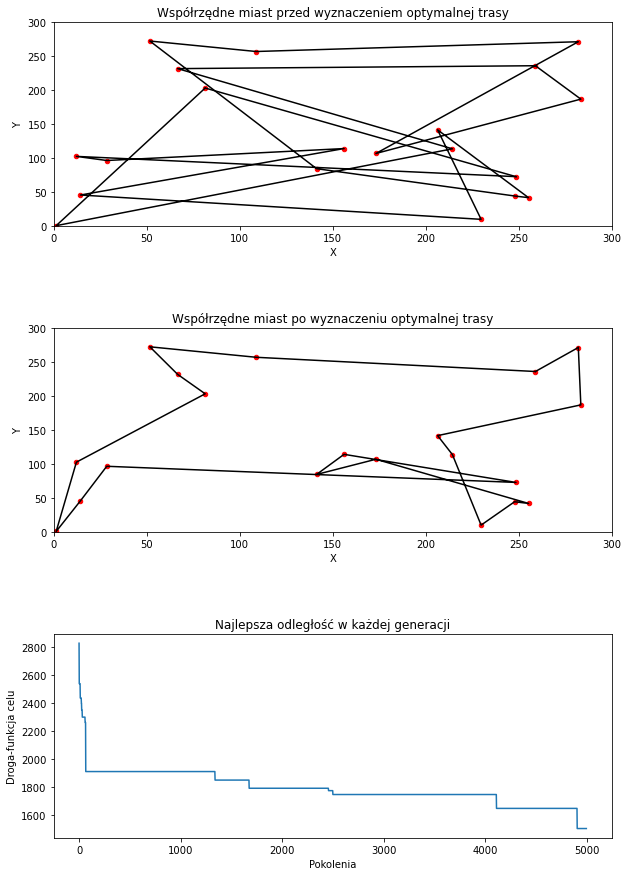

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math 

N = 20 #ilość miast
pop_size= 100 #rozmiar populacji
p_crossover=0.7 #prawdopodobieństwo krzyżowania
mutation_rate=0.3 #prawdopodobieństwo mutacji
selection_method="rank"  #metoda selekcji - rankingowa
#selection_method="roulette" #- metoda ruletki

 #wylosowanie współrzędnych miast na siatce 300x300
x = np.random.uniform(0, 300, size=N)
y = np.random.uniform(0, 300, size=N)
points = zip(x, y)
cities = list(points) 

#stworzenie funkcji celu
# def total_distance(cities,order):  
#     distance = 0
#     for i in range(len(order)-1):
#         dx = cities[order[i+1]][0] - cities[order[i]][0]
#         dy = cities[order[i+1]][1] - cities[order[i]][1]
#         distance += math.sqrt(dx*dx + dy*dy)
#     dx = cities[order[0]][0] - cities[order[-1]][0]
#     dy = cities[order[0]][1] - cities[order[-1]][1]
#     distance += math.sqrt(dx*dx + dy*dy)
#     return round(distance, 2)

#stworzenie funkcji celu
distance_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        distance = np.sqrt((cities[i][0] - cities[j][0])**2 + (cities[i][1] - cities[j][1])**2)
        distance_matrix[i][j] = distance
        distance_matrix[j][i] = distance

def total_distance(cities, order, distance_matrix):
    distance = 0
    for i in range(len(order)-1):
        city1 = order[i]
        city2 = order[i+1]
        distance += distance_matrix[city1][city2]
    distance += distance_matrix[order[-1]][order[0]] 
    return distance

#stworzenie populacji
populacja = []
for _ in range(pop_size):
    order = np.random.permutation(N)
    distance = total_distance(cities,order,distance_matrix)
    populacja.append((order, distance))
    
# selekcja 
def roulette_selection(population):
    fitness = np.array([chromosome[1] for chromosome in population])
    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    cum_probabilities = np.cumsum(probabilities)
    selekcja = []
    for _ in range(len(population)):
        r = np.random.rand()
        chromosome = np.searchsorted(cum_probabilities, r)
        selekcja.append(population[chromosome])
    return selekcja

def rank_selection(population):
    sort_population = sorted(population, key=lambda x: x[1], reverse=False)
    fitness_sum = sum([i for i in range(1, len(population) + 1)])
    probabilities = [i/fitness_sum for i in range(1, len(population) + 1)]
    cum_probabilities = np.cumsum(probabilities)
    selekcja = []
    for _ in range(len(population)):
        r = np.random.rand()
        chromosome = np.searchsorted(cum_probabilities, r)
        selekcja.append(sort_population[chromosome])
    return selekcja

def selection(population,selection_method):
    if selection_method == "roulette":
        select = roulette_selection(population)
    elif selection_method == "rank":
        select = rank_selection(population)
    else:
        raise ValueError("Invalid selection method. Choose 'roulette' or 'rank'.")
    return select

#krzyżowanie
def order_crossover(parent1, parent2, p_crossover):
    child1 = parent1.copy()
    child2 = parent2.copy()
    n = len(parent1)
    
    # jeśli nie krzyżujemy to zwracamy rodziców
    if np.random.rand() > p_crossover:
        return child1, child2
    
    # losowy locus początkowy i końcowy
    while True:
        locus1 = np.random.randint(0, n-1)
        locus2 = np.random.randint(locus1+1, n)
        if locus2 - locus1 >= 2:
            break
            
    # kopiowanie sekwencji miast między locusami
    cities1 = parent1[locus1:locus2+1]
    cities2 = parent2[locus1:locus2+1]

    # usuwanie miast z sekwencji w osobnikach potomnych
    child1[locus1:locus2+1] = [-1]*len(cities2)
    child2[locus1:locus2+1] = [-1]*len(cities1)
    
    # wstawienie sekwencji miast z pierwszego rodzica do drugiego dziecka i odwrotnie
    child1[locus1:locus2+1] = cities2
    child2[locus1:locus2+1] = cities1
    
    # usuwanie dublikatów w sekwencji miast w osobnikach potomnych
    for i in range(n):
        if child1[i] in cities2:
            child1[i] = -1
        if child2[i] in cities1:
            child2[i] = -1
    for i in range(n):
        if child1[i] == -1:
            for j in range(len(parent2)):
                if parent2[j] not in child1:
                    child1[i] = parent2[j]
                    break
        if child2[i] == -1:
            for j in range(len(parent1)):
                if parent1[j] not in child2:
                    child2[i] = parent1[j]
                    break
    return child1, child2


#mutacja
def mutation(chromosome, mutation_rate):
    mutated_chromosome = chromosome.copy()
    for i in range(len(chromosome)):
        if np.random.random() < mutation_rate and len(chromosome) > 1:
            j = np.random.randint(0, len(chromosome))
            mutated_chromosome[i], mutated_chromosome[j] = mutated_chromosome[j], mutated_chromosome[i]
    return mutated_chromosome

distances = []
generation = 0 # do końca pętli
c = 0 # do końca pętli
changemax = 500 * N   # przez ile maksymalnie funkcja celu może się nie zmieniać
max_generation = 5000 # maksymalna ilość pokoleń

while c < changemax and generation < max_generation-1:
    # ocena populacji
    for i in range(pop_size):
        order = populacja[i][0]
        distance = populacja[i][1]
        populacja[i] = (order, distance)

    # znalezienie najlepszego osobnika w danym pokoleniu
    best_individual = min(populacja, key=lambda x: x[1])
    distances.append(best_individual[1])

    # zastępowanie populacji najlepszymi osobnikami
    new_populacja = [best_individual]

    for i in range(1, pop_size):
        parents = selection(populacja, selection_method=selection_method)
        parent1 = parents[0][0]
        parent2 = parents[1][0]
        child1, child2 = order_crossover(parent1, parent2, p_crossover)
        mutated_child1 = mutation(child1, mutation_rate)
        mutated_child2 = mutation(child2, mutation_rate)

        if not any((mutated_child1 == x[0]).all() for x in populacja):
            distance1 = total_distance(cities, mutated_child1, distance_matrix)
            populacja.append((mutated_child1, distance1))
        if not any((mutated_child2 == x[0]).all() for x in populacja):
            distance2 = total_distance(cities, mutated_child2, distance_matrix)
            populacja.append((mutated_child2, distance2))

    new_populacja = sorted(populacja, key=lambda x: x[1])[:pop_size]

    # zastępowanie najsłabszych osobników w populacji najlepszymi nowymi osobnikami
    populacja[pop_size:] = new_populacja[:pop_size]

    generation += 1
    c += 1
    
# Wykresy
cities_ordered = [cities[i] for i in best_individual[0]]

fig, ax = plt.subplots(3,1,figsize=(10,15))
plt.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')
ax[0].scatter(x, y,c='red', s=20)
ax[0].plot(x,y, '-k')
ax[0].plot([cities[-1][0], cities[0][0]], [cities[-1][1], cities[0][1]], '-k')
ax[0].set_xlim(0,300)
ax[0].set_ylim(0,300)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Współrzędne miast przed wyznaczeniem optymalnej trasy')

ax[1].scatter(x, y,c='red', s=20)
ax[1].plot(*zip(*cities_ordered), '-k')
ax[1].plot([cities_ordered[-1][0], cities_ordered[0][0]], [cities_ordered[-1][1], cities_ordered[0][1]], '-k')
ax[1].set_xlim(0,300)
ax[1].set_ylim(0,300)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('Współrzędne miast po wyznaczeniu optymalnej trasy')

ax[2].plot(distances)
ax[2].set_xlabel('Pokolenia')
ax[2].set_ylabel('Droga-funkcja celu')
ax[2].set_title('Najlepsza odległość w każdej generacji')
